In [21]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from statsmodels.formula.api import ols

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('kc_house_data.csv')

In [3]:
print(df.shape)
df.head(8)

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711


# Column Descriptions

* **id** - unique identified for a house
* **date** - Date house was sold
* **price** -  Price is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of bathrooms/bedrooms
* **sqft_living** -  Square footage of the home
* **sqft_lot** - Square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [4]:
# Checking for null values.
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [5]:
# I am going to fill null values with '0' because I'll assume there is no waterfront view, home hasn't 
# been renovated, and no one has viewed the property yet.
df['view'] = df['view'].fillna(0)
df['waterfront'] = df['waterfront'].fillna(0)
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [6]:
# sqft_basement includes 454 records with a '?'.
df['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [7]:
# replacing the '?' with 0.0 values.
df['sqft_basement'] = (df['sqft_basement'].map(
    lambda x: 0.0 if x == '?' else x)).astype(float)

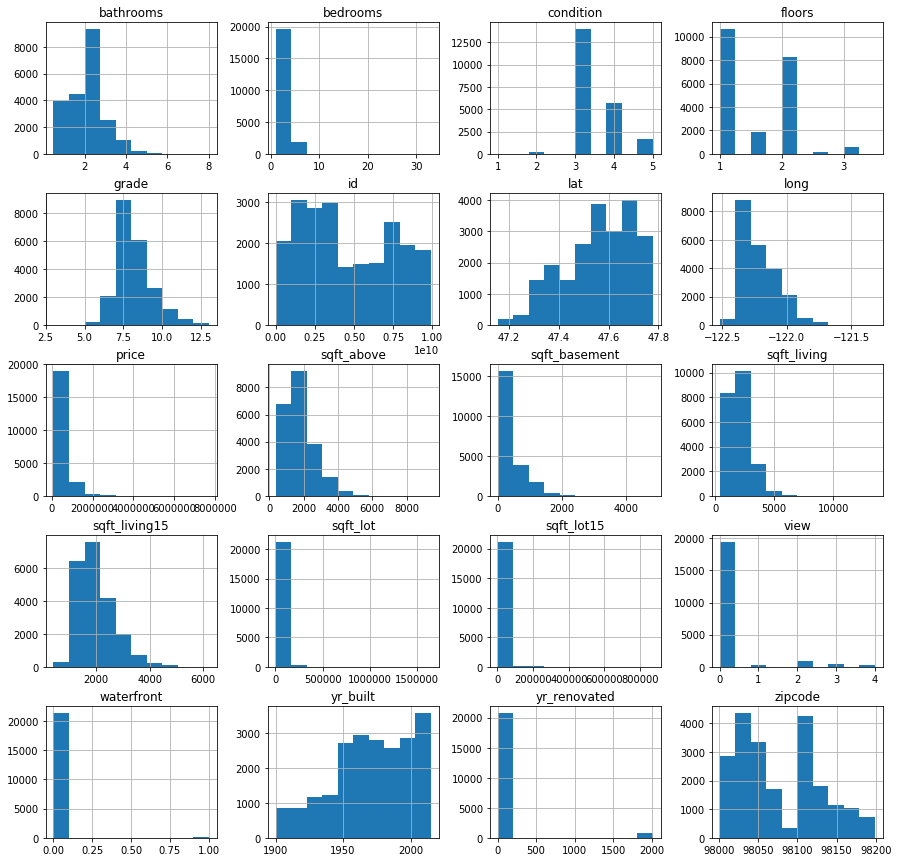

In [8]:
# Checking for distribution of variables in histogram plots.
df.hist(figsize=(15,15));

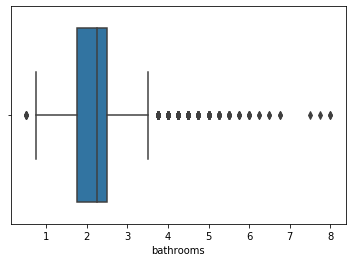

In [9]:
# Checking for bathroom outliers.
sns.boxplot(x=df['bathrooms']);

In [10]:
# Removing bathroom outliers.
df = df[df['bathrooms'] <= 4]
print(df.shape)

(21331, 21)


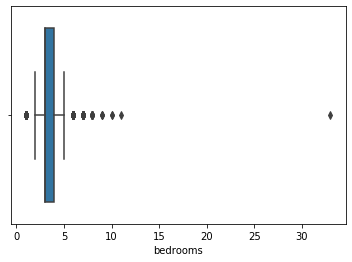

In [11]:
# Checking for bedroom outliers.
sns.boxplot(x=df['bedrooms']);

In [12]:
# Removing records with bedroom outliers.
df = df[df['bedrooms'] < 6]
print(df.shape)

(21061, 21)


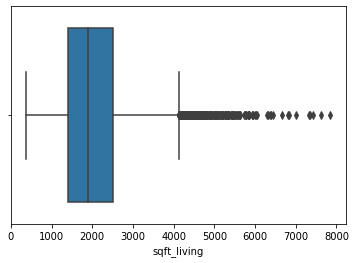

In [13]:
# Checking for outliers in sqft_living.
sns.boxplot(x=df['sqft_living'])

In [14]:
# Removing 337 records from data set where sqft_living > 4200.
df = df[df['sqft_living'] < 4200]
df.shape

(20661, 21)

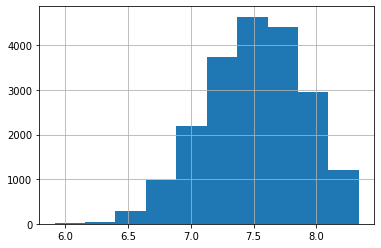

In [22]:
# Log transformation on sqft_living.
df['sqft_living'] = np.log(df['sqft_living'])
df['sqft_living'].hist();

In [ ]:
# Square root transformation of sqft_above.
df['sqft_above'] = np.sqrt(df['sqft_above'])
df['sqft_above'].hist()

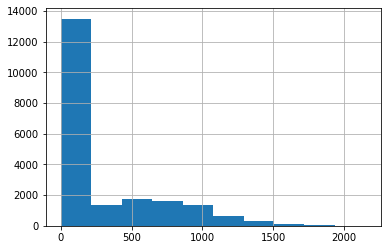

In [15]:
# There looks to be a ton of houses without a basement, so I decided to create a boolean field instead.
df['sqft_basement'].hist();

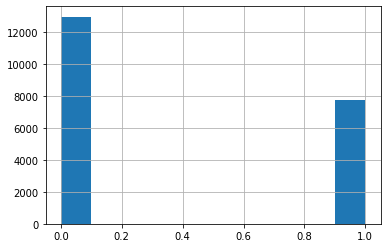

In [16]:
df['basement'] = df.apply(lambda row: 0 if row['sqft_basement'] == 0 else 1, axis=1)
df['basement'].hist();

In [ ]:
# Creating age of home variable.
df['age'] = (df['yr_built'].max() - df['yr_built'])
df.age.head(3)

In [ ]:
# Square root transformation of home age.
df.age = np.sqrt(df['age'])
df['age'].hist();

In [ ]:
# Log transformation of sqft_lot.
df['sqft_lot'] = np.log(df['sqft_lot'])
df['sqft_lot'].hist();

In [ ]:
# Log transformation of sqft_lot15.
df['sqft_lot15'] = np.log(df['sqft_lot15'])
df['sqft_lot15'].hist();

In [23]:
# There are a lot of homes that haven't been viewed. I thought I'd create a boolean field instead.
df['view'] = df.apply(lambda row: 0 if row['view'] == 0 else 1, axis=1)

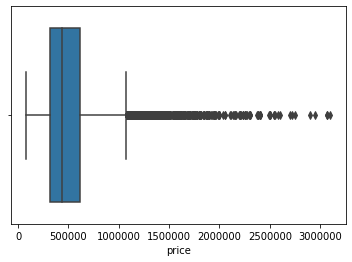

In [18]:
# Checking for outliers in price.
sns.boxplot(x=df['price']);

In [19]:
# Removing pricing outliers. I decided to cut it off at $1.5 million homes. This removes 224 records.
df = df[df['price'] < 1500000]
print(df.shape)

(20420, 22)


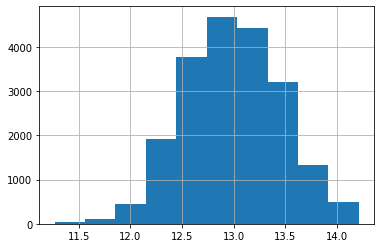

In [24]:
# Log transformation of price.
df['price_log'] = np.log(df['price'])
df['price_log'].hist();

In [ ]:
'''df['lat'] = (df.lat - min(df.lat)) / (max(df.lat) - min(df.lat))'''

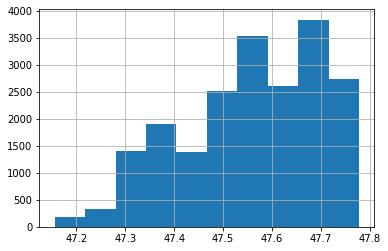

In [20]:
df['lat'].hist()

In [ ]:
# Min-max scaling.
'''df['price_log'] = ( df.price_log - min(df.price_log) ) / ( max(df.price_log) - min(df.price_log) )
df['sqft_living'] = ( df.sqft_living - min(df.sqft_living) ) / ( max(df.sqft_living) - min(df.sqft_living) )
df['sqft_above'] = ( df.sqft_above - min(df.sqft_above) ) / ( max(df.sqft_above) - min(df.sqft_above) )
df['sqft_living15'] = ( df.sqft_living15 - min(df.sqft_living15) ) / ( max(df.sqft_living15) - min(df.sqft_living15) )
df['sqft_lot15'] = ( df.sqft_lot15 - min(df.sqft_lot15) ) / ( max(df.sqft_lot15) - min(df.sqft_lot15) )
df['sqft_lot'] = ( df.sqft_lot - min(df.sqft_lot) ) / ( max(df.sqft_lot) - min(df.sqft_lot) )
df['age'] = ( df.age - min(df.age) ) / ( max(df.age) - min(df.age) )'''



In [ ]:
# Upding data type for categorical features
'''df.waterfront = df.waterfront.astype('int').astype('category')
df.view = df.view.astype('int').astype('category')
df.condition = df.condition.astype('int').astype('category')
df.grade = df.grade.astype('int').astype('category')
df.bedrooms = df.bedrooms.astype('float').astype('category')
df.floors = df.floors.astype('float').astype('category')
df.bathrooms = df.bathrooms.astype('float').astype('category')
df.basement = df.basement.astype('int').astype('category')'''

In [ ]:
# Creating dummy variables for category features.
'''waterfront_dummies = pd.get_dummies(df.waterfront, prefix='wat', drop_first=True)
basement_dummies = pd.get_dummies(df.basement, prefix='base', drop_first=True)
view_dummies = pd.get_dummies(df.view, prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(df.condition, prefix='cond', drop_first=True)
grade_dummies = pd.get_dummies(df.grade, prefix='gra', drop_first=True)
bedroom_dummies = pd.get_dummies(df.bedrooms, prefix='bed', drop_first=True)
bedroom_floors = pd.get_dummies(df.floors, prefix='fl', drop_first=True)
bathrooms_dummies = pd.get_dummies(df.bathrooms, prefix='bath', drop_first=True)

df = df.drop(['waterfront','view','condition', 'grade', 'bedrooms', 'floors', 'bathrooms', 'basement'], axis=1)

df = pd.concat([df, waterfront_dummies, view_dummies, condition_dummies, grade_dummies,
               bedroom_dummies, bedroom_floors, bathrooms_dummies, basement_dummies], axis=1)'''

In [ ]:
# Reviewing my variable transformations & min max scaling in histogram plots. 
df.hist(figsize=(18,18));

In [ ]:
# Checking for issues with mulitcollinearity.
plt.figure(figsize=(12,8))
sns.heatmap(abs(df.corr())>0.75, center=0);

In [26]:
# After reviewing my transformed variables and correlation heatmap, I have decided to drop some fields:
df.drop(['id', 'date', 'price'], axis=1, inplace=True)
# sqft_basement was replaced with a boolean value 'basement'.

# Splitting the data before selecting features for the model.

In [27]:
X = df.drop(['price_log'], axis=1)
y = df['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=3)

# Selecing my features and modeling

In [28]:
# I'm going to select features using scikit-learn's Recursive Feature Elimination module.
# Then I'll fit the model with linear regression.

linreg = LinearRegression(fit_intercept=True)
selector = RFE(linreg, n_features_to_select=25)
selector = selector.fit(X_train, y_train)

In [29]:
y_hat_train = selector.predict(X_train)
y_hat_test = selector.predict(X_test)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

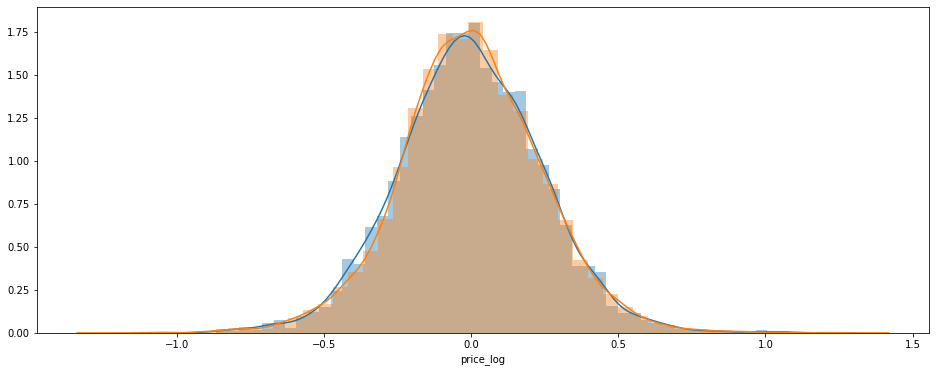

In [30]:
# Distribution of residuals

plt.figure(figsize=(16,6))
sns.distplot(test_residuals)
sns.distplot(train_residuals)
plt.show();

In [31]:
# Evaluate mean squared error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.058583144038713966
Test Mean Squarred Error: 0.058653333305959364


In [32]:
# Root mean squared error

print(np.sqrt(metrics.mean_squared_error(y_train, y_hat_train)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))

0.24203955056707976
0.24218450261310975


In [33]:
# Scikitlearn's R2 score:
sklearn.metrics.r2_score(y_test, y_hat_test)

0.7303006742686917

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test, y_hat_test, edgecolors=(0, 0, 0))
ax.plot(y_test, y_test, 'k--', lw=4, color='y')
sns.regplot(x=y_test, y=y_hat_test, ax=ax, line_kws={"color": "red"})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

In [ ]:
# Predictor contribution percentage (table)

X = X
y = y
model_reg = LinearRegression()
linreg.fit(X, y)
model_coef = pd.DataFrame()
preds = list()
coef_log = list()
coef = list()
sum_coef = 0
percent_coef = list()
i = 0
for col in X.columns:
    preds.append(X.columns.values[i])
    coef_log.append(linreg.coef_[i])
    coef.append(10**(linreg.coef_[i]))
    sum_coef += 10**(linreg.coef_[i])
    i += 1
model_coef['Predictor'] = preds
model_coef['Coefficient(log)'] = coef_log
model_coef['Coefficient'] = coef
for c in model_coef.Coefficient:
    percent_coef.append(c/sum_coef*100)
model_coef['Contribution(%)'] = percent_coef
model_coef.sort_values(by=['Coefficient'], ascending=False)

In [ ]:
outcome = 'price_log'
predictors = df.drop(['price', 'price_log'], axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum
model = ols(formula=formula, data=df).fit()
model.summary()